C:\Users\cemer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Fold 1: Final Training Loss: 0.0001, Final Validation Loss: 0.0001
Fold 2: Final Training Loss: 0.0000, Final Validation Loss: 0.0001
Fold 3: Final Training Loss: 0.0000, Final Validation Loss: 0.0000
Fold 4: Final Training Loss: 0.0001, Final Validation Loss: 0.0001
Fold 5: Final Training Loss: 0.0000, Final Validation Loss: 0.0000


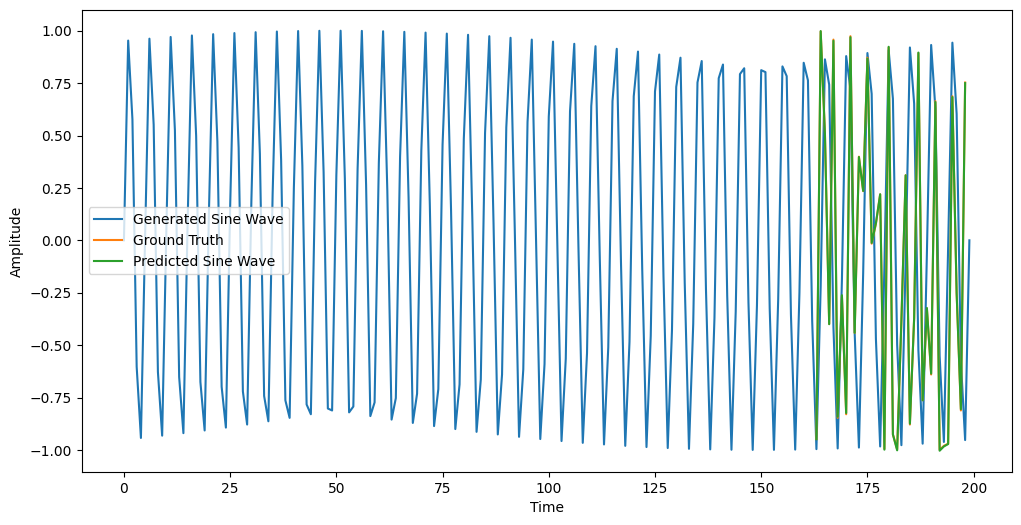

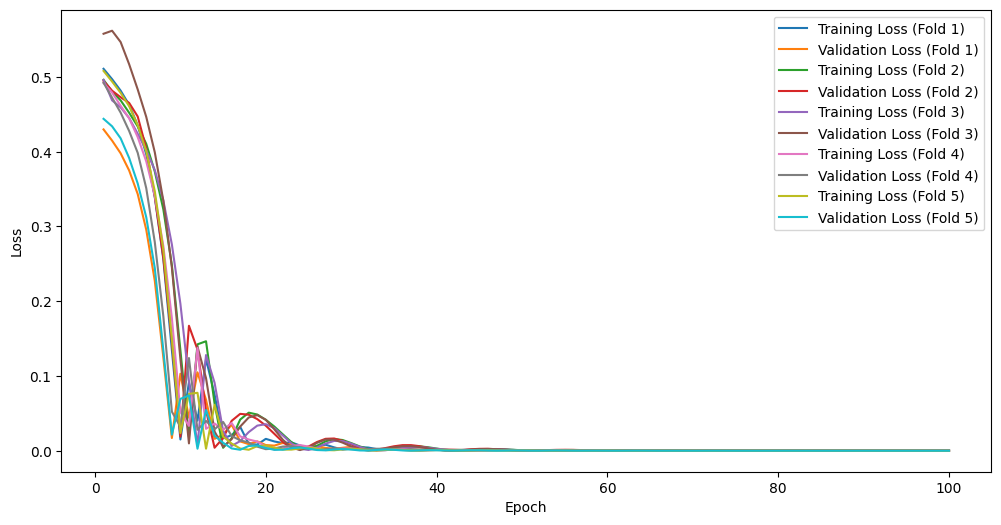

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate sinusoidal time series data
def generate_sin_wave(freq, num_samples, sample_rate):
    x = np.linspace(0, num_samples / sample_rate, num_samples)
    y = np.sin(2 * np.pi * freq * x)
    return y

# Create input-target pairs for the LSTM model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        seq = data[i : (i + seq_length)]
        X.append(seq)
        target = data[i + seq_length]
        y.append(target)
    return np.array(X), np.array(y)

# Define the LSTM model with dropout
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(TimeSeriesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Generate sinusoidal time series data
freq = 2
num_samples = 200
sample_rate = 10
data = generate_sin_wave(freq, num_samples, sample_rate)

# Prepare the data for the LSTM model
seq_length = 20
X, y = create_sequences(data, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], 1)

# Function to train and validate the model
def train_and_validate(X_train, y_train, X_val, y_val, num_epochs, device, save_best_model=False):
    # Create the model
    model = TimeSeriesLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_tensor)
        loss = criterion(y_train_pred, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

        if save_best_model and val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save(model.state_dict(), "best_model.pt")

    return train_losses, val_losses


# Split the dataset into training, validation, and testing sets (80% train, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set initial hyperparameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
learning_rate = 0.01
dropout_prob = 0.2
weight_decay = 1e-5
num_epochs = 100

# Perform 5-fold cross-validation
num_epochs = 100
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses_all = []
val_losses_all = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val[train_indices], X_train_val[val_indices]
    y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]

    train_losses, val_losses = train_and_validate(X_train, y_train, X_val, y_val, num_epochs, device)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)

    print(f"Fold {fold + 1}: Final Training Loss: {train_losses[-1]:.4f}, Final Validation Loss: {val_losses[-1]:.4f}")

# Update hyperparameters to their best values (just an example, use cross-validation results)
hidden_size = 64

# Train the final model on the combined training and validation sets
# Train the final model on the combined training and validation sets
model = TimeSeriesLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)  # Add this line
train_losses, _ = train_and_validate(X_train_val, y_train_val, X_val, y_val, num_epochs, device, save_best_model=True)


# Evaluate the final model on the test set
model = TimeSeriesLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
y_pred = model(X_test_tensor).detach().cpu().numpy()


# Plot the generated sine wave, ground truth, and predicted sine wave
plt.figure(figsize=(12, 6))
plt.plot(data, label="Generated Sine Wave")
plt.plot(range(len(X_train_val) + seq_length, len(data) - 1), y_test, label="Ground Truth")
plt.plot(range(len(X_train_val) + seq_length, len(data) - 1), y_pred, label="Predicted Sine Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Plot training and validation losses
plt.figure(figsize=(12, 6))
for i in range(k_folds):
    plt.plot(range(1, num_epochs + 1), train_losses_all[i], label=f"Training Loss (Fold {i + 1})")
    plt.plot(range(1, num_epochs + 1), val_losses_all[i], label=f"Validation Loss (Fold {i + 1})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
